In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

In [2]:
df = pd.read_csv("State_time_series.csv")
df.head()

,Date,RegionName,DaysOnZillow_AllHomes,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,...,ZHVI_BottomTier,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental
0,1996-04-30,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45600.0,99500.0,79500.0,79000.0,140200.0,NaN,NaN,NaN,NaN,NaN
1,1996-04-30,Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67100.0,78900.0,103600.0,107500.0,168700.0,NaN,NaN,NaN,NaN,NaN
2,1996-04-30,Arkansas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38400.0,70300.0,64400.0,64500.0,115200.0,NaN,NaN,NaN,NaN,NaN
3,1996-04-30,California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95100.0,136100.0,157900.0,162000.0,270600.0,NaN,NaN,NaN,NaN,NaN
4,1996-04-30,Colorado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,82700.0,99400.0,128100.0,133600.0,209300.0,NaN,NaN,NaN,NaN,NaN


In [3]:
data = df[["Date", "RegionName", "ZHVI_AllHomes"]].copy()
print(data.dtypes)

Date              object
RegionName        object
ZHVI_AllHomes    float64
dtype: object


In [4]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.sort_values(['RegionName', 'Date']).reset_index(drop=True)
data.dtypes

Date             datetime64[ns]
RegionName               object
ZHVI_AllHomes           float64
dtype: object

In [5]:
print("Focused dataset shape:", data.shape)
print("Columns:", data.columns.tolist())
print("Missing values before cleaning:")
print(data.isnull().sum())

Focused dataset shape: (13212, 3)
Columns: ['Date', 'RegionName', 'ZHVI_AllHomes']
Missing values before cleaning:
Date               0
RegionName         0
ZHVI_AllHomes    774
dtype: int64


In [6]:
data['ZHVI_AllHomes_cleaned'] = data.groupby('RegionName')['ZHVI_AllHomes'].transform(
    lambda x: x.interpolate(method='linear').ffill().bfill()
)



print("Missing values after cleaning:")
print(data.isnull().sum())
print(f"Final dataset shape: {data.shape}")

print("Regions with missing values:")
print(data[data['ZHVI_AllHomes_cleaned'].isnull()]['RegionName'].unique())

Missing values after cleaning:
Date                       0
RegionName                 0
ZHVI_AllHomes            774
ZHVI_AllHomes_cleaned    356
dtype: int64
Final dataset shape: (13212, 4)
Regions with missing values:
['Louisiana' 'UnitedStates']


In [7]:
def remove_outliers(group, window=6, threshold=3, method="median"):
    group = group.copy()  # avoid SettingWithCopyWarning
    
    if len(group) < window:
        return group
    
    rolling_median = group.rolling(window=window, center=True, min_periods=1).median()
    deviation = np.abs(group - rolling_median)
    mad = deviation.median()
    
    if mad > 0:
        outlier_mask = deviation > (threshold * mad)
        
        if method == "median":
            group[outlier_mask] = rolling_median[outlier_mask]
        elif method == "nan":
            group[outlier_mask] = np.nan
            group = group.interpolate(method='linear').ffill().bfill()
            
    return group


In [8]:
data['ZHVI_AllHomes_cleaned'] = data.groupby('RegionName')['ZHVI_AllHomes_cleaned'].transform(
    lambda x: remove_outliers(x, window=12, threshold=2, method="nan")
)


C:\Users\Prime\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Prime\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


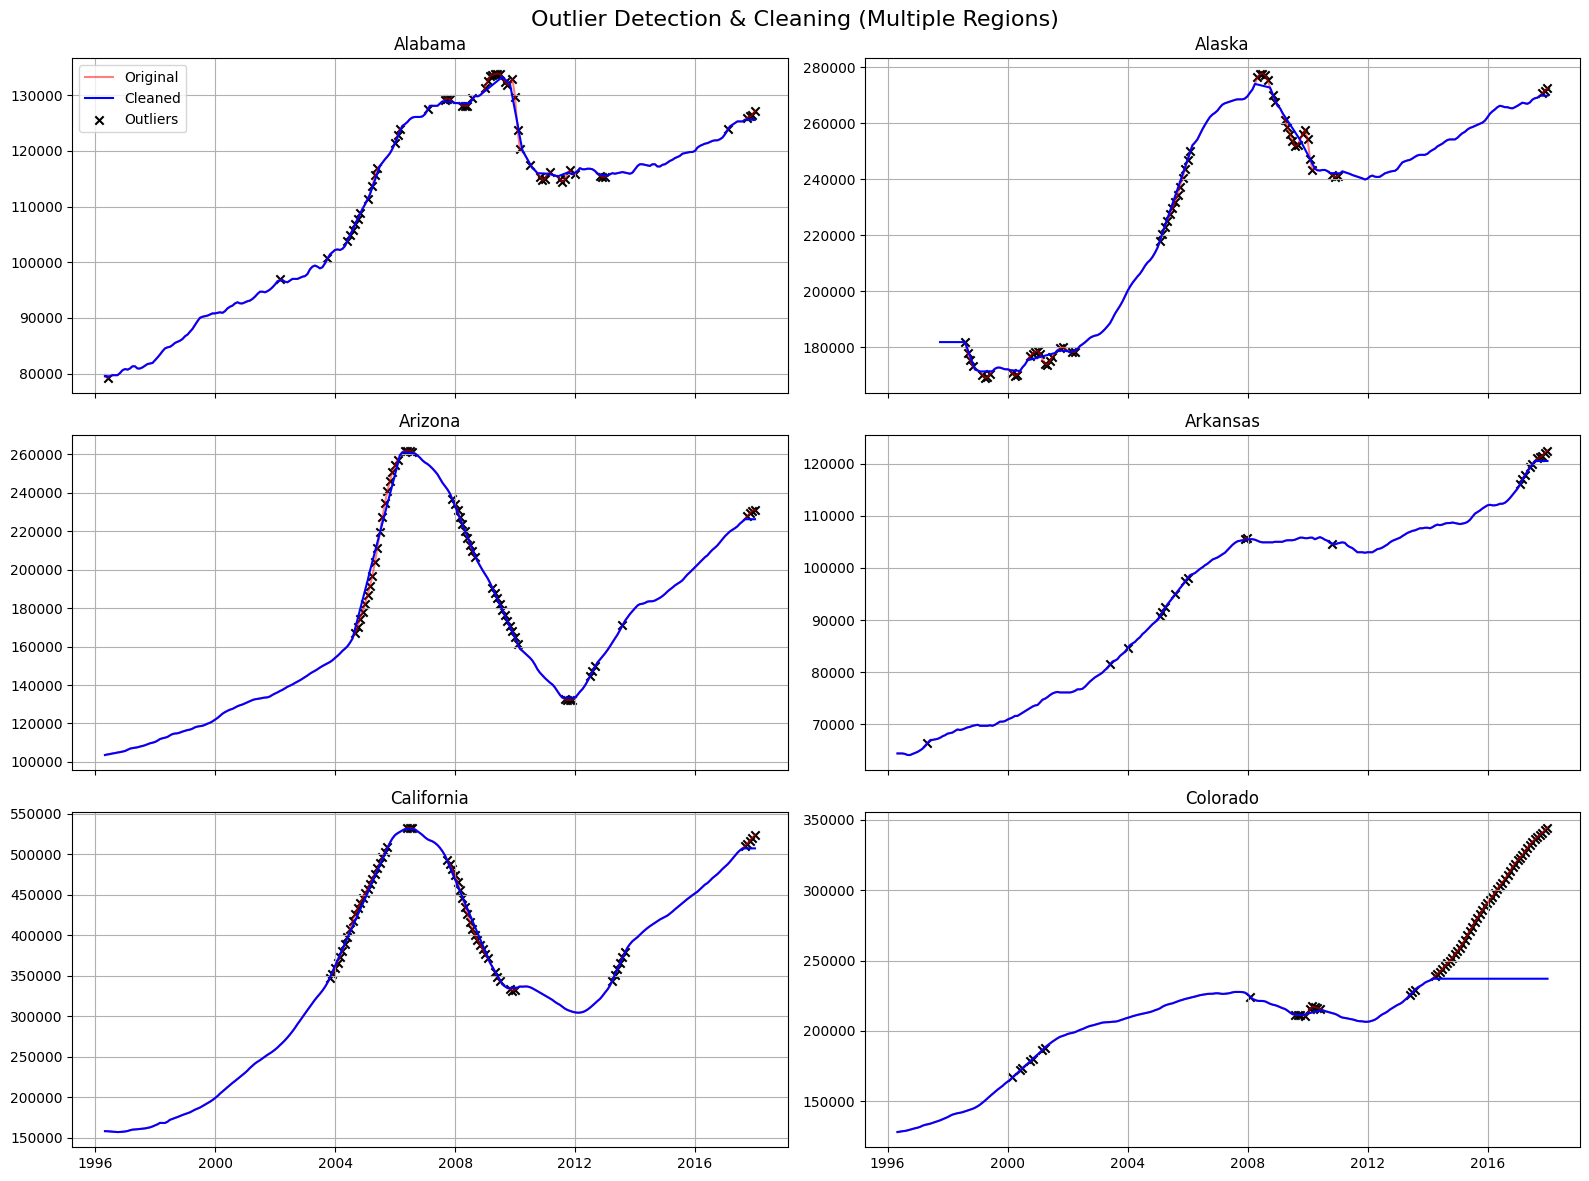

In [9]:
regions = data['RegionName'].unique()[:6]  # pick first 6 regions (adjust as needed)

def detect_outliers(group, window=12, threshold=2):
    rolling_median = group.rolling(window=window, center=True, min_periods=1).median()
    deviation = np.abs(group - rolling_median)
    mad = deviation.median()
    if mad == 0:
        return pd.Series(False, index=group.index)
    return deviation > (threshold * mad)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12), sharex=True, sharey=False)
axes = axes.flatten()

for i, region in enumerate(regions):
    subset = data[data['RegionName'] == region].copy()
    subset['Outlier'] = detect_outliers(subset['ZHVI_AllHomes'], window=12, threshold=2)
    
    axes[i].plot(subset['Date'], subset['ZHVI_AllHomes'], 
                 label="Original", color="red", alpha=0.5)
    axes[i].plot(subset['Date'], subset['ZHVI_AllHomes_cleaned'], 
                 label="Cleaned", color="blue")
    axes[i].scatter(subset.loc[subset['Outlier'], 'Date'],
                    subset.loc[subset['Outlier'], 'ZHVI_AllHomes'],
                    color="black", marker="x", label="Outliers")
    
    axes[i].set_title(region)
    axes[i].grid(True)
    if i == 0:
        axes[i].legend()

plt.suptitle("Outlier Detection & Cleaning (Multiple Regions)", fontsize=16)
plt.tight_layout()
plt.show()


In [10]:
data.head()

,Date,RegionName,ZHVI_AllHomes,ZHVI_AllHomes_cleaned
0,1996-04-30,Alabama,79500.0,79500.0
1,1996-05-31,Alabama,79200.0,79500.0
2,1996-06-30,Alabama,79500.0,79500.0
3,1996-07-31,Alabama,79700.0,79700.0
4,1996-08-31,Alabama,79700.0,79700.0


In [11]:

prophet_data = data[['Date', 'RegionName', 'ZHVI_AllHomes_cleaned']].copy()
prophet_data = prophet_data.rename(columns={
    'Date': 'ds',
    'ZHVI_AllHomes_cleaned': 'y'
})

print("Data prepared for Prophet:")
print("Shape:", prophet_data.shape)
print("Columns:", prophet_data.columns.tolist())
print("\nSample data:")
print(prophet_data.head())


print(f"\nDate range: {prophet_data['ds'].min()} to {prophet_data['ds'].max()}")
print(f"Number of regions: {prophet_data['RegionName'].nunique()}")
print(f"Average data points per region: {len(prophet_data) / prophet_data['RegionName'].nunique():.0f}")

Data prepared for Prophet:
Shape: (13212, 3)
Columns: ['ds', 'RegionName', 'y']

Sample data:
          ds RegionName        y
0 1996-04-30    Alabama  79500.0
1 1996-05-31    Alabama  79500.0
2 1996-06-30    Alabama  79500.0
3 1996-07-31    Alabama  79700.0
4 1996-08-31    Alabama  79700.0

Date range: 1996-04-30 00:00:00 to 2017-12-31 00:00:00
Number of regions: 52
Average data points per region: 254


In [12]:
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [13]:
states = prophet_data['RegionName'].unique()

In [14]:
all_forecasts = {}

# =====================
# Train Prophet for all states
# =====================
for state in states:
    print("=" * 80)
    print(f" Training Prophet model for {state} ...")
    
    # Prepare data
    state_data = prophet_data[prophet_data['RegionName'] == state][['ds', 'y']].dropna()
    
    if len(state_data) < 24:
        print(f"Skipping {state} (not enough valid records: {len(state_data)})")
        continue
    
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    
    try:
        model.fit(state_data)
    except ValueError as e:
        print(f" Skipping {state} due to error: {e}")
        continue
    
    # Forecast next 48 months
    future = model.make_future_dataframe(periods=48, freq='M')
    forecast = model.predict(future)
    
    # Store both model and forecast
    all_forecasts[state] = {
        "model": model,
        "forecast": forecast,
        "history": state_data
    }
    
    # Print quick preview
    future_only = forecast[forecast['ds'] > state_data['ds'].max()].head(3)
    print(f"\n {state.upper()} - Preview of Next 3 Months:")
    print(future_only[['ds','yhat','yhat_lower','yhat_upper']])


 Training Prophet model for Alabama ...


18:30:25 - cmdstanpy - INFO - Chain [1] start processing
18:30:25 - cmdstanpy - INFO - Chain [1] done processing
18:30:26 - cmdstanpy - INFO - Chain [1] start processing



 ALABAMA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  125480.190868  124335.756725  126527.229263
262 2018-02-28  125686.295822  124650.066224  126741.692542
263 2018-03-31  125857.919156  124689.080964  126969.903616
 Training Prophet model for Alaska ...


18:30:26 - cmdstanpy - INFO - Chain [1] done processing
18:30:26 - cmdstanpy - INFO - Chain [1] start processing



 ALASKA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
244 2018-01-31  272109.673296  270958.705550  273242.896020
245 2018-02-28  272741.296617  271519.543168  274024.116533
246 2018-03-31  273183.128117  271893.237727  274481.238609
 Training Prophet model for Arizona ...


18:30:26 - cmdstanpy - INFO - Chain [1] done processing
18:30:26 - cmdstanpy - INFO - Chain [1] start processing



 ARIZONA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  230147.618703  228452.455841  231796.851669
262 2018-02-28  231426.828085  229681.941841  233060.158320
263 2018-03-31  232495.654875  230563.495023  234111.709839
 Training Prophet model for Arkansas ...


18:30:27 - cmdstanpy - INFO - Chain [1] done processing
18:30:27 - cmdstanpy - INFO - Chain [1] start processing



 ARKANSAS - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  118967.337493  117871.842780  119988.977914
262 2018-02-28  119239.000185  118229.401207  120302.300961
263 2018-03-31  119490.988690  118410.530293  120596.982947
 Training Prophet model for California ...


18:30:27 - cmdstanpy - INFO - Chain [1] done processing
18:30:27 - cmdstanpy - INFO - Chain [1] start processing



 CALIFORNIA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  517882.692690  514942.113547  520974.433653
262 2018-02-28  520622.525556  517442.434969  523670.830735
263 2018-03-31  523510.069644  520283.905810  526709.431079
 Training Prophet model for Colorado ...


18:30:27 - cmdstanpy - INFO - Chain [1] done processing
18:30:28 - cmdstanpy - INFO - Chain [1] start processing



 COLORADO - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  238984.954276  237530.933920  240312.332410
262 2018-02-28  239097.701968  237646.240015  240542.736861
263 2018-03-31  239184.291478  237650.376824  240617.084322
 Training Prophet model for Connecticut ...


18:30:28 - cmdstanpy - INFO - Chain [1] done processing
18:30:28 - cmdstanpy - INFO - Chain [1] start processing



 CONNECTICUT - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  243398.558539  242222.310873  244480.748973
262 2018-02-28  243672.222725  242533.454398  244742.864928
263 2018-03-31  243934.994810  242705.875352  245125.710737
 Training Prophet model for Delaware ...


18:30:28 - cmdstanpy - INFO - Chain [1] done processing
18:30:28 - cmdstanpy - INFO - Chain [1] start processing



 DELAWARE - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  223377.155119  221911.051700  224806.116263
262 2018-02-28  224131.078403  222600.581677  225610.393209
263 2018-03-31  224620.715796  223125.769753  226173.401322
 Training Prophet model for DistrictofColumbia ...


18:30:28 - cmdstanpy - INFO - Chain [1] done processing
18:30:29 - cmdstanpy - INFO - Chain [1] start processing



 DISTRICTOFCOLUMBIA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
233 2018-01-31  561585.745012  555872.257812  567051.690904
234 2018-02-28  563828.388560  558260.875118  569305.692887
235 2018-03-31  566412.835011  560518.817536  572095.854682
 Training Prophet model for Florida ...


18:30:29 - cmdstanpy - INFO - Chain [1] done processing
18:30:29 - cmdstanpy - INFO - Chain [1] start processing



 FLORIDA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  216316.454820  214917.289453  217674.076207
262 2018-02-28  217664.357375  216209.277510  219048.878786
263 2018-03-31  219074.832293  217411.053710  220678.260086
 Training Prophet model for Georgia ...


18:30:29 - cmdstanpy - INFO - Chain [1] done processing



 GEORGIA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  160434.376935  159759.585988  161051.651726
262 2018-02-28  161171.202283  160508.616125  161820.862656
263 2018-03-31  161938.256080  161242.110228  162608.799884
 Training Prophet model for Hawaii ...


18:30:30 - cmdstanpy - INFO - Chain [1] start processing
18:30:31 - cmdstanpy - INFO - Chain [1] done processing



 HAWAII - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  621551.943421  618795.857240  624489.436551
262 2018-02-28  624511.951891  621386.186149  627729.125806
263 2018-03-31  627495.167803  624241.682246  630731.686669
 Training Prophet model for Idaho ...


18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing



 IDAHO - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  193577.358418  191379.094246  195833.288827
262 2018-02-28  194566.017554  192316.281980  196875.516046
263 2018-03-31  195164.535424  192775.432266  197325.902506
 Training Prophet model for Illinois ...


18:30:34 - cmdstanpy - INFO - Chain [1] start processing
18:30:35 - cmdstanpy - INFO - Chain [1] done processing



 ILLINOIS - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  171064.962972  170328.270178  171844.194945
262 2018-02-28  171601.316150  170848.658483  172361.801275
263 2018-03-31  172041.372373  171203.666601  172840.356672
 Training Prophet model for Indiana ...


18:30:35 - cmdstanpy - INFO - Chain [1] start processing
18:30:36 - cmdstanpy - INFO - Chain [1] done processing



 INDIANA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  122237.251848  121150.410697  123340.277877
262 2018-02-28  122494.561110  121423.493610  123610.392743
263 2018-03-31  122794.884669  121655.063727  123899.539188
 Training Prophet model for Iowa ...


18:30:36 - cmdstanpy - INFO - Chain [1] start processing
18:30:36 - cmdstanpy - INFO - Chain [1] done processing



 IOWA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  129158.994471  128088.300101  130249.525863
262 2018-02-28  129458.337894  128486.241584  130445.413589
263 2018-03-31  129664.441493  128601.914774  130696.315190
 Training Prophet model for Kansas ...


18:30:37 - cmdstanpy - INFO - Chain [1] start processing
18:30:38 - cmdstanpy - INFO - Chain [1] done processing



 KANSAS - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  127253.699775  126444.049088  128026.751887
262 2018-02-28  127465.077891  126676.936024  128280.307913
263 2018-03-31  127666.090285  126797.518575  128546.012372
 Training Prophet model for Kentucky ...


18:30:39 - cmdstanpy - INFO - Chain [1] start processing
18:30:39 - cmdstanpy - INFO - Chain [1] done processing



 KENTUCKY - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  135520.721093  134594.882230  136496.822782
262 2018-02-28  135947.454629  134922.655250  136884.880692
263 2018-03-31  136279.551658  135345.451356  137235.881409
 Training Prophet model for Louisiana ...
Skipping Louisiana (not enough valid records: 0)
 Training Prophet model for Maine ...


18:30:40 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing



 MAINE - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  206939.270658  204762.544677  209022.603407
262 2018-02-28  207729.282170  205664.569037  209766.006787
263 2018-03-31  208442.135850  206288.241372  210596.421623
 Training Prophet model for Maryland ...


18:30:41 - cmdstanpy - INFO - Chain [1] start processing
18:30:41 - cmdstanpy - INFO - Chain [1] done processing



 MARYLAND - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  273154.898193  271789.176608  274553.509639
262 2018-02-28  273962.371172  272577.207025  275398.260409
263 2018-03-31  274753.673669  273346.737594  276205.744078
 Training Prophet model for Massachusetts ...


18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:43 - cmdstanpy - INFO - Chain [1] done processing



 MASSACHUSETTS - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  380940.269301  378847.972468  383015.773214
262 2018-02-28  382451.989868  380227.916571  384631.776490
263 2018-03-31  384041.778432  381855.027726  386432.200296
 Training Prophet model for Michigan ...


18:30:43 - cmdstanpy - INFO - Chain [1] start processing
18:30:44 - cmdstanpy - INFO - Chain [1] done processing



 MICHIGAN - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  137687.106712  136969.913615  138408.000989
262 2018-02-28  138343.063953  137618.741507  139061.847917
263 2018-03-31  139020.231466  138292.370289  139748.050033
 Training Prophet model for Minnesota ...


18:30:44 - cmdstanpy - INFO - Chain [1] start processing
18:30:45 - cmdstanpy - INFO - Chain [1] done processing



 MINNESOTA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  211617.204617  210192.385911  213007.542523
262 2018-02-28  212536.285516  211101.777788  214021.465721
263 2018-03-31  213304.896898  211924.814251  214762.585072
 Training Prophet model for Mississippi ...


18:30:46 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing



 MISSISSIPPI - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  113325.177044  112461.630376  114255.867812
262 2018-02-28  113516.110603  112588.217245  114472.734754
263 2018-03-31  113735.912272  112777.067877  114685.192478
 Training Prophet model for Missouri ...


18:30:47 - cmdstanpy - INFO - Chain [1] start processing
18:30:47 - cmdstanpy - INFO - Chain [1] done processing



 MISSOURI - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  142631.553841  141592.943285  143600.281044
262 2018-02-28  143173.038237  142143.663733  144195.735674
263 2018-03-31  143520.584663  142464.696695  144631.726332
 Training Prophet model for Montana ...


18:30:48 - cmdstanpy - INFO - Chain [1] start processing
18:30:49 - cmdstanpy - INFO - Chain [1] done processing



 MONTANA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
240 2018-01-31  204300.130287  200948.365901  207692.383252
241 2018-02-28  204959.403954  201306.788627  208377.691451
242 2018-03-31  204967.105834  201618.403115  208408.481567
 Training Prophet model for Nebraska ...


18:30:50 - cmdstanpy - INFO - Chain [1] start processing
18:30:50 - cmdstanpy - INFO - Chain [1] done processing



 NEBRASKA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  151070.223665  149864.862848  152240.602661
262 2018-02-28  151542.325755  150344.995327  152608.135045
263 2018-03-31  152067.745473  150875.533866  153306.773611
 Training Prophet model for Nevada ...


18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing



 NEVADA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  251585.581204  249330.242554  253906.336807
262 2018-02-28  253257.737778  250770.328555  255693.105085
263 2018-03-31  254675.363405  252154.040458  257464.759840
 Training Prophet model for NewHampshire ...


18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing



 NEWHAMPSHIRE - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  248536.249805  247184.979403  249912.448194
262 2018-02-28  249511.187117  248030.036527  250967.796298
263 2018-03-31  250540.755111  249186.111570  251993.943887
 Training Prophet model for NewJersey ...


18:30:53 - cmdstanpy - INFO - Chain [1] start processing
18:30:54 - cmdstanpy - INFO - Chain [1] done processing



 NEWJERSEY - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  306951.375181  305541.191795  308318.522515
262 2018-02-28  307843.184291  306457.588298  309336.931873
263 2018-03-31  308528.703808  307096.540694  310126.833118
 Training Prophet model for NewMexico ...


18:30:54 - cmdstanpy - INFO - Chain [1] start processing
18:30:55 - cmdstanpy - INFO - Chain [1] done processing



 NEWMEXICO - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  173118.463437  170770.546899  175830.993997
262 2018-02-28  173543.914992  171075.173954  176323.683741
263 2018-03-31  173863.867512  171425.447274  176477.992200
 Training Prophet model for NewYork ...


18:30:56 - cmdstanpy - INFO - Chain [1] start processing
18:30:56 - cmdstanpy - INFO - Chain [1] done processing



 NEWYORK - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  296420.737252  292124.995925  300769.524543
262 2018-02-28  297534.183516  293307.350337  301816.354445
263 2018-03-31  298703.264865  294507.681715  302729.912391
 Training Prophet model for NorthCarolina ...


18:30:57 - cmdstanpy - INFO - Chain [1] start processing
18:30:57 - cmdstanpy - INFO - Chain [1] done processing



 NORTHCAROLINA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  161448.999415  160294.207557  162552.830236
262 2018-02-28  161980.106106  160846.282026  163013.976435
263 2018-03-31  162451.700616  161211.403510  163583.790562
 Training Prophet model for NorthDakota ...


18:30:58 - cmdstanpy - INFO - Chain [1] start processing
18:30:58 - cmdstanpy - INFO - Chain [1] done processing



 NORTHDAKOTA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
159 2018-01-31  202939.720799  201193.942819  204542.716622
160 2018-02-28  202852.183801  201278.899834  204489.840873
161 2018-03-31  203202.968547  201613.965361  204899.817204
 Training Prophet model for Ohio ...


18:30:58 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing



 OHIO - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  128347.295255  127804.442122  128903.886985
262 2018-02-28  128742.259064  128194.425113  129280.194756
263 2018-03-31  129149.464558  128598.752025  129689.566043
 Training Prophet model for Oklahoma ...


18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:31:00 - cmdstanpy - INFO - Chain [1] done processing



 OKLAHOMA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  118498.095454  117198.256042  119759.906591
262 2018-02-28  118956.866194  117755.738300  120198.909220
263 2018-03-31  119521.895458  118294.183315  120725.595334
 Training Prophet model for Oregon ...


18:31:01 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing



 OREGON - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  318517.282886  315894.437836  321352.689708
262 2018-02-28  320587.132468  317684.159854  323380.134044
263 2018-03-31  322652.272748  319887.425484  325481.920108
 Training Prophet model for Pennsylvania ...


18:31:02 - cmdstanpy - INFO - Chain [1] start processing
18:31:02 - cmdstanpy - INFO - Chain [1] done processing



 PENNSYLVANIA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  159892.391951  159143.408383  160661.575316
262 2018-02-28  160256.407772  159497.714453  160993.237505
263 2018-03-31  160588.163152  159733.536076  161375.390210
 Training Prophet model for RhodeIsland ...


18:31:03 - cmdstanpy - INFO - Chain [1] start processing
18:31:03 - cmdstanpy - INFO - Chain [1] done processing



 RHODEISLAND - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  256053.657309  254253.864495  258060.677440
262 2018-02-28  257094.808575  255221.028499  259043.796031
263 2018-03-31  257991.021744  255918.326918  259939.129480
 Training Prophet model for SouthCarolina ...


18:31:03 - cmdstanpy - INFO - Chain [1] start processing
18:31:04 - cmdstanpy - INFO - Chain [1] done processing



 SOUTHCAROLINA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  144479.967621  142352.408102  146637.593193
262 2018-02-28  145032.706478  143024.278505  147177.887131
263 2018-03-31  145347.556999  143146.701228  147589.239549
 Training Prophet model for SouthDakota ...


18:31:04 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing



 SOUTHDAKOTA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
260 2018-01-31  175741.211320  174174.108967  177174.814044
261 2018-02-28  176419.444684  174958.196293  177902.724138
262 2018-03-31  176998.910117  175528.198530  178450.512506
 Training Prophet model for Tennessee ...


18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:06 - cmdstanpy - INFO - Chain [1] done processing



 TENNESSEE - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  134107.489506  133366.446478  134869.989752
262 2018-02-28  134465.104164  133752.050426  135194.941813
263 2018-03-31  134841.418392  134030.725074  135586.604915
 Training Prophet model for Texas ...


18:31:06 - cmdstanpy - INFO - Chain [1] start processing
18:31:07 - cmdstanpy - INFO - Chain [1] done processing



 TEXAS - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  173040.801044  171910.222333  174223.930396
262 2018-02-28  173971.735759  172786.650458  175265.248232
263 2018-03-31  174906.610570  173675.515610  176139.180171
 Training Prophet model for UnitedStates ...
Skipping UnitedStates (not enough valid records: 0)
 Training Prophet model for Utah ...


18:31:08 - cmdstanpy - INFO - Chain [1] start processing
18:31:08 - cmdstanpy - INFO - Chain [1] done processing



 UTAH - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  256027.531802  253380.049733  258715.646013
262 2018-02-28  257317.724851  254518.843447  259945.151877
263 2018-03-31  258245.075842  255492.643116  260908.696406
 Training Prophet model for Vermont ...


18:31:08 - cmdstanpy - INFO - Chain [1] start processing
18:31:09 - cmdstanpy - INFO - Chain [1] done processing



 VERMONT - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
260 2018-01-31  219613.175492  213982.278516  224621.861279
261 2018-02-28  219957.954176  214197.082566  225378.653161
262 2018-03-31  219702.676903  214550.796644  225348.970782
 Training Prophet model for Virginia ...


18:31:09 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing



 VIRGINIA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  246329.676204  245296.358089  247360.898347
262 2018-02-28  246948.452101  245876.264104  248045.791441
263 2018-03-31  247514.083278  246390.758984  248606.124847
 Training Prophet model for Washington ...


18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing



 WASHINGTON - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  341998.174190  338644.362280  345094.784851
262 2018-02-28  344169.672085  341192.547279  347324.389915
263 2018-03-31  346282.656135  343211.881248  349573.335788
 Training Prophet model for WestVirginia ...


18:31:12 - cmdstanpy - INFO - Chain [1] start processing
18:31:12 - cmdstanpy - INFO - Chain [1] done processing



 WESTVIRGINIA - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  103532.331256  102153.359200  104935.161781
262 2018-02-28  103679.670263  102374.520963  105030.133884
263 2018-03-31  103969.315791  102581.792505  105423.728750
 Training Prophet model for Wisconsin ...


18:31:13 - cmdstanpy - INFO - Chain [1] start processing
18:31:13 - cmdstanpy - INFO - Chain [1] done processing



 WISCONSIN - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
261 2018-01-31  166054.153903  164698.791841  167420.210119
262 2018-02-28  166494.519399  165163.943054  167784.158582
263 2018-03-31  166897.651558  165622.711428  168174.369449
 Training Prophet model for Wyoming ...


18:31:14 - cmdstanpy - INFO - Chain [1] start processing
18:31:15 - cmdstanpy - INFO - Chain [1] done processing



 WYOMING - Preview of Next 3 Months:
            ds           yhat     yhat_lower     yhat_upper
237 2018-01-31  199226.975777  197207.259298  201256.500098
238 2018-02-28  199469.394166  197434.415150  201559.495310
239 2018-03-31  199518.279837  197568.655344  201639.945747


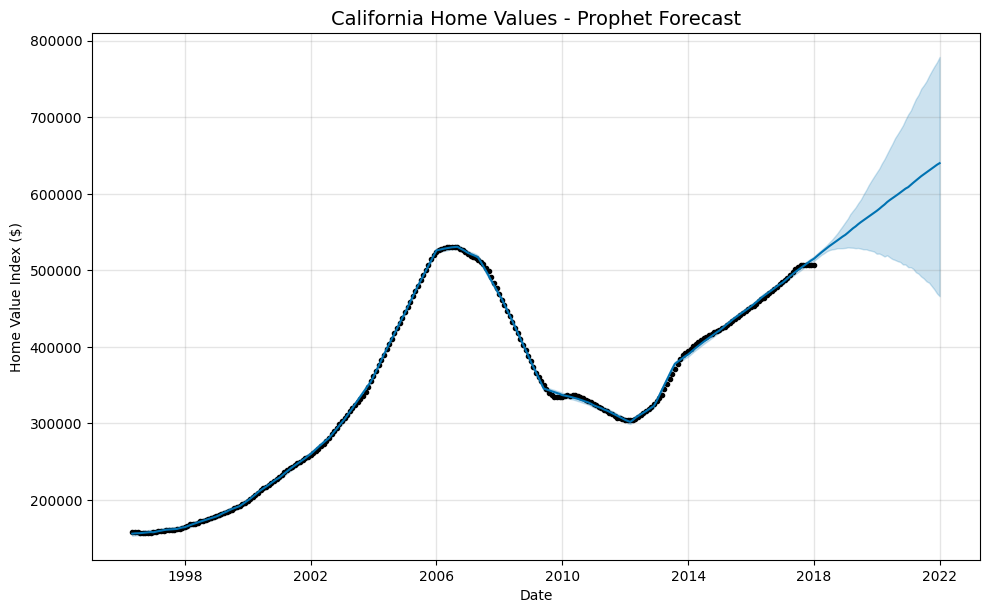

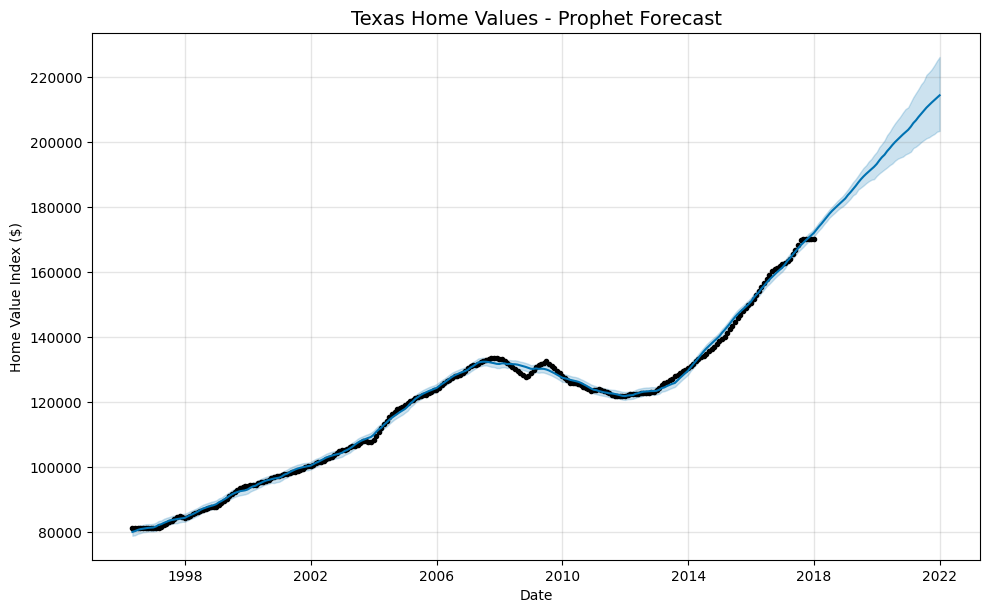

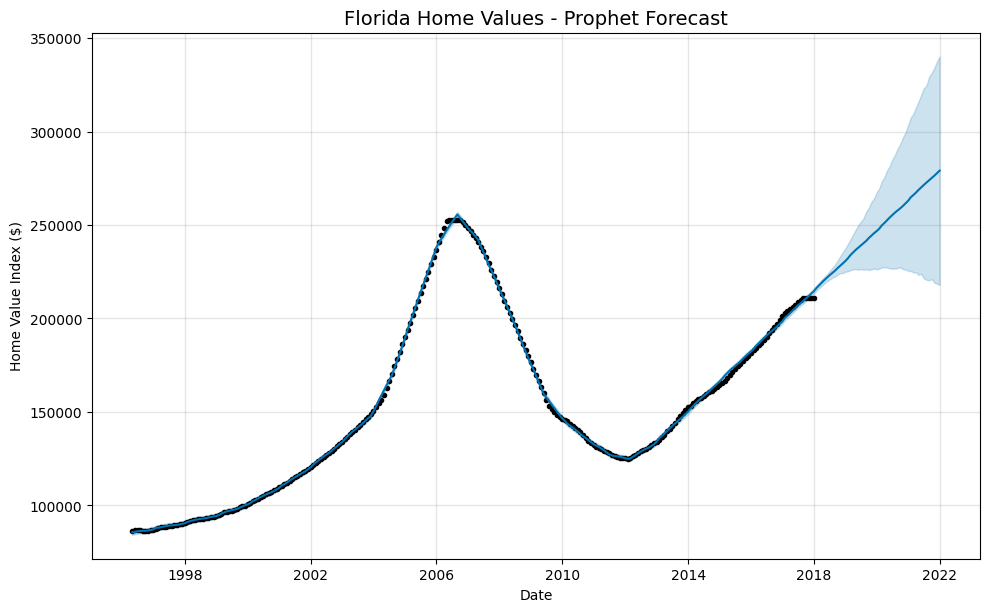

In [15]:
# =====================
# Plot only selected states (after training)
# =====================
selected_states = ["California", "Texas", "Florida"]

for state in selected_states:
    if state in all_forecasts:
        model = all_forecasts[state]["model"]
        forecast = all_forecasts[state]["forecast"]
        
        fig = model.plot(forecast)
        plt.title(f'{state} Home Values - Prophet Forecast', fontsize=14)
        plt.xlabel('Date')
        plt.ylabel('Home Value Index ($)')
        plt.show()


In [19]:
# Ensure models folder exists
os.makedirs("models", exist_ok=True)

single_file = os.path.join("models", "all_states_models.pkl")
joblib.dump(all_forecasts, single_file)

print(f"All models and forecasts saved in a single file  {single_file}")


All models and forecasts saved in a single file  models\all_states_models.pkl
